In [1]:
# basic dependencies

import numpy as np
from numpy import loadtxt
from numpy import savetxt

import random
import pandas as pd
import math
import time
import joblib

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

###########

# torch dependencies
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": device} # set tensors to GPU, if multiple GPUs please set cuda:x properly


torch.set_printoptions(precision=3)

# NN dependencies
from torch.utils.data import DataLoader

from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

###########

# botorch dependencies
import botorch

# data related
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize, normalize

# surrogate model specific
from botorch.models.gp_regression import SingleTaskGP, FixedNoiseGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch import fit_gpytorch_model

# qNEHVI specific
from botorch.optim.optimize import optimize_acqf
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement

# utilities
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
from botorch.utils.multi_objective.hypervolume import infer_reference_point
from typing import Optional
from torch import Tensor
from botorch.exceptions import BadInitialCandidatesWarning

import warnings

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

###########
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, WhiteKernel

# pymoo dependencies
import pymoo

from pymoo.factory import get_problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.unsga3 import UNSGA3
from pymoo.factory import get_sampling, get_crossover, get_mutation, get_reference_directions, get_termination
from pymoo.optimize import minimize
from pymoo.util.termination.default import MultiObjectiveDefaultTermination
from pymoo.core.repair import Repair

###########

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d, Axes3D

# this is for the colorbar, you can change the cmap if you prefer other colour schemes
from matplotlib.cm import ScalarMappable
cm = plt.cm.get_cmap('viridis')

# function to return the std dev across runs
def ci(y, N_TRIALS):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

###########
from skopt.space import Space
from skopt.sampler import Lhs

In [2]:
def optimize_qnehvi_noconstr(problem, ref_point, initial_x, # must haves
                    N_BATCH, BATCH_SIZE, 
                    random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with qNEHVI")

    t0 = time.time()

    # some initializing 
    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    
    ##########
    
    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, standard_bounds)
    
    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = train_obj_noisy

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    
    # original location for an extra HV check wrt to initial samples
    
    ########## ########## ########## start of iteration loop


    # training loop for N_BATCH iterations
    for iteration in range(1, N_BATCH + 1):    

        t3 = time.time()
                
        # fit the surrogate model
        fit_gpytorch_model(mll)    
                
        ##########
            
        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on
        
        ##########
        
        # propose candidates given defined qNEHVI acq func given model and latest observed training data
        new_x, _ = optimize_acqf(
                        acq_function=acq_func,
                        bounds=standard_bounds, # since train_x was normalized
                        q=BATCH_SIZE, # no of candidates to propose in parallel
                        num_restarts=2, # no of restarts if q candidates fail to show improvement
                        raw_samples=256,  # pool of samples to choose the starting points from
                        options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                        )
        
        # unormalize our training inputs back to original problem bounds
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)

        # feed new proposed observations into objective func to get its new ground truth
        new_obj = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        
        ##########
        
        # computing HV of current candidate list
        pareto_mask = is_non_dominated(train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
        pareto_y = train_obj[pareto_mask] # take only points that fit the 2nd check
        volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        
        hvs.append(volume)
        
        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, standard_bounds) # dont forget to renormalize!
        train_y = train_obj_noisy

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        
        ##########
        
        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")
            
        del new_x, new_obj, new_obj_noisy, train_x_gp, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial     
        
        ########## ########## ########## end of iteration loop

    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")       
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj]).cpu().numpy()

def optimize_nsga3_noconstr(problem, ref_point, initial_x, # must haves
                   N_BATCH, pop_size,
                   ref_num=10, # as a rule of thumb, pop_size>ref_num,
                   noise=0, random_state=np.random.randint(0, 1000000, (1,)).item(), verbose=False):
    
    print("Optimizing with NSGA-III")
    
    t0 = time.time()    
    
    # some initializing
    hv=Hypervolume(ref_point=ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    ##########
    
    noise=noise

    # define a pymoo problem class based on the torch class
    class PymooProblem(ElementwiseProblem):

        def __init__(self):
            super().__init__(n_var=problem.n_var,
                             n_obj=problem.n_obj,
                             xl=problem.bounds[0].cpu().numpy(),
                             xu=problem.bounds[1].cpu().numpy())

        def _evaluate(self, X, out, *args, **kwargs):
            # base input/output from torch class
            train_x = torch.tensor(X.tolist(), **tkwargs).unsqueeze(dim=0)
            
            # take the noisy observations for algo
            train_obj = problem.evaluate(train_x)
            train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)

            # output the noisy observations instead
            out["F"] = -train_obj_noisy.cpu().numpy() # flip since botorch assumes maximisation vs pymoo minimization
            
    ##########        

    pymooproblem = PymooProblem()

    # create the reference directions to be used for the optimization
    ref_dirs = get_reference_directions("energy", problem.n_obj, ref_num, seed=random_state)
    
    # initial sampling
    sampling = initial_x.cpu().numpy()
    
    # create the algorithm object
    algorithm = UNSGA3(pop_size=pop_size,
                      ref_dirs=ref_dirs,
                      sampling=sampling,
                     )

    # execute the optimization, take N_BATCH+1 since 1st iteration is just the initial sampling
    res = minimize(pymooproblem, algorithm, seed=random_state, termination=('n_gen', N_BATCH+1),
                   verbose=verbose, save_history=True)
    
    ##########
    
    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")
    
    ##########
    
    # convert population data into tensor form
    # initial data
    train_x = torch.tensor(res.history[0].pop.get("X").tolist(), **tkwargs)
    train_obj = problem.evaluate(train_x) 
    # population at each iteration
    for i in range(1,N_BATCH+1): # don't forget we did +1 for total iterations
        new_x = torch.tensor(res.history[i].pop.get("X").tolist(), **tkwargs)
        new_obj = problem.evaluate(new_x)
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])

    ##########
        
    # calculate hypervolume based on checks, done on noiseless train_obj and train_con
    iterdict = {}
    a = 0
    b = N_BATCH
    for i in range(0, N_BATCH+1):

        iterdict[i] = (a, b)
        # a stays at zero
        b+=pop_size
    
    for i in range(0,N_BATCH):
        hvs_obj = train_obj[iterdict[i][0]:iterdict[i][1]]

        pareto_mask = is_non_dominated(hvs_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
        pareto_y = hvs_obj[pareto_mask] # take only points that fit the 2nd check
        volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        
        hvs.append(volume)

    print("DONE!\n")
        
    return hvs, torch.hstack([train_x, train_obj]).cpu().numpy()

In [3]:
class Net(nn.Module):
    def __init__(self,n_input_nodes, n_hidden_layers, n_hidden_nodes):
        """
        n_feature : number of input feature nodes
        n_hidden : number of nodes in the hidden layer
        n_output : number of nodes in the output layer
        
        d_hidden : number of hidden layers
        """
        
        super(Net, self).__init__() ## inherit init function from the ancestor
        
        self.input = nn.Linear(n_input_nodes, n_hidden_nodes)
        self.hidden = nn.Linear(n_hidden_nodes, n_hidden_nodes)
        self.predict = nn.Linear(n_hidden_nodes, 1)
        
        self.l_hidden = n_hidden_layers
        
    def forward(self, x):
        x = self.input(x)
        
        for i in range(self.l_hidden):
            x = self.hidden(x)
            x = F.relu(x)
        x = self.predict(x)
        
        return x
    
    def fit(self, x, y, epochs=100):

        optimizer = torch.optim.Adam(self.parameters()) ## SGD gave 'nan'
        loss_func = nn.MSELoss()
      
        for t in range(epochs):

            pred = self.forward(x)     
            loss = loss_func(pred, y)
            optimizer.zero_grad()
            loss.backward()  # backpropagation
            optimizer.step() # update gradient
            
models_tdict = joblib.load('models_tdict') 
xscaler = joblib.load('xscaler')
yscaler = joblib.load('yscaler')

In [4]:
target_dict = {'SL': 'SLUMP(cm)',
               'CS': 'Compressive Strength (28-day)(Mpa)',  
              }

df = pd.read_csv('slump_test.data')
df

,No,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,1,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
1,2,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14
2,3,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81
3,4,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08
4,5,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82
...,...,...,...,...,...,...,...,...,...,...,...
98,99,248.3,101.0,239.1,168.9,7.7,954.2,640.6,0.0,20.0,49.97
99,100,248.0,101.0,239.9,169.1,7.7,949.9,644.1,2.0,20.0,50.23
100,101,258.8,88.0,239.6,175.3,7.6,938.9,646.0,0.0,20.0,50.50
101,102,297.1,40.9,239.9,194.0,7.5,908.9,651.8,27.5,67.0,49.17


In [8]:
'''
define the problem statement and objective function, using the regressor we previously trained
although there exists tool to infer ref point, we can take origin 0 as a good start
'''


lowerbound = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], **tkwargs)
upperbound = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], **tkwargs)

class Problem(torch.nn.Module):
    # must define these!
    n_var = 7
    n_obj = 2
    n_constr = 0
    
    ref_point = torch.tensor([0, 0], **tkwargs)
        
    # input bounds, don't forget to change according to n_var! 
    bounds = torch.vstack([lowerbound,upperbound])
    
    def evaluate(X):
        n_models = 10
        
        y_pred_top = []
        for i in range(X.shape[0]):
            
            input_x = X[i].float()

            y_pred_list1 = []
            for key in target_dict.keys():

                y_pred_list2 = []
                for i in range(n_models):
                    m = models_tdict['{:}_{:}'.format(key, i)]
                    m.eval()
                    y_pred = m.forward(input_x)
                    y_pred_list2.append(y_pred.detach().cpu().numpy())

                y_pred_list1.append(np.array(y_pred_list2).mean(axis=0))
                
            y_pred_top.append(np.array(y_pred_list1).flatten())
        
        output = torch.tensor(np.array(y_pred_top), **tkwargs)
        
        return output

In [6]:
N_BATCH = 100
BATCH_SIZE = 8

noise = 0
trial = 1
verbose = True

initial_x = draw_sobol_samples(bounds=Problem.bounds,n=1, q=2*(Problem.n_var+1), seed=trial).squeeze(0)

hvs_qnehvi, train_qnehvi = optimize_qnehvi_noconstr(Problem, Problem.ref_point, initial_x,
                                                    N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                                                    noise=noise, random_state=trial, verbose=verbose,
                                                   )

hvs_nsga3, train_nsga3 = optimize_nsga3_noconstr(Problem, Problem.ref_point, initial_x,
                                                    N_BATCH=N_BATCH, pop_size=BATCH_SIZE, ref_num=BATCH_SIZE,
                                                    noise=noise, random_state=trial, verbose=verbose,
                                                   )

Optimizing with qNEHVI


C:\Users\user\anaconda3\lib\site-packages\botorch\fit.py:143: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is C:\Users\user\AppData\Local\Temp/torch/kernels. This warning will appear only once per process. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cuda\jit_utils.cpp:860.)
  warnings.warn(w.message, w.category)
C:\Users\user\anaconda3\lib\site-packages\gpytorch\lazy\lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:1672.)
  Linv = torch.triangular_solve(Eye, 

Batch  1 of 100: Hypervolume = 0.95, time = 7.42s.
Batch  2 of 100: Hypervolume = 1.03, time = 6.12s.
Batch  3 of 100: Hypervolume = 1.06, time = 7.15s.
Batch  4 of 100: Hypervolume = 1.08, time = 6.93s.
Batch  5 of 100: Hypervolume = 1.10, time = 6.56s.
Batch  6 of 100: Hypervolume = 1.10, time = 8.26s.
Batch  7 of 100: Hypervolume = 1.12, time = 7.86s.
Batch  8 of 100: Hypervolume = 1.25, time = 7.53s.
Batch  9 of 100: Hypervolume = 1.25, time = 7.54s.
Batch 10 of 100: Hypervolume = 1.25, time = 7.70s.
Batch 11 of 100: Hypervolume = 1.25, time = 8.88s.
Batch 12 of 100: Hypervolume = 1.25, time = 8.75s.
Batch 13 of 100: Hypervolume = 1.25, time = 8.57s.
Batch 14 of 100: Hypervolume = 1.26, time = 8.55s.
Batch 15 of 100: Hypervolume = 1.28, time = 6.41s.
Batch 16 of 100: Hypervolume = 1.28, time = 8.89s.
Batch 17 of 100: Hypervolume = 1.28, time = 9.00s.
Batch 18 of 100: Hypervolume = 1.28, time = 9.78s.
Batch 19 of 100: Hypervolume = 1.28, time = 9.80s.
Batch 20 of 100: Hypervolume = 

   51 |     416 |       6 |  0.001771403 |            f
   52 |     424 |       6 |  0.005980403 |        nadir
   53 |     432 |       6 |  0.004867626 |        ideal
   54 |     440 |       6 |  0.003077294 |        ideal
   55 |     448 |       6 |  0.00000E+00 |            f
   56 |     456 |       6 |  0.00000E+00 |            f
   57 |     464 |       6 |  0.000378934 |            f
   58 |     472 |       6 |  0.00000E+00 |            f
   59 |     480 |       6 |  0.048550464 |        nadir
   60 |     488 |       7 |  0.027297936 |            f
   61 |     496 |       7 |  0.001547448 |            f
   62 |     504 |       7 |  0.001018934 |            f
   63 |     512 |       7 |  0.003538909 |            f
   64 |     520 |       7 |  0.00000E+00 |            f
   65 |     528 |       7 |  0.00000E+00 |            f
   66 |     536 |       8 |  0.007399231 |        nadir
   67 |     544 |       7 |  0.001559376 |            f
   68 |     552 |       7 |  0.00000E+00 |      

In [6]:
N_BATCH = 500
pop_size = 100
random_state = 1
verbose = True

ref_point = torch.tensor([0, 0], **tkwargs)
hv=Hypervolume(ref_point=ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
hvs = [] # create a blank array to append the scores at each batch/iteration for that run

problem = Problem

# define a pymoo problem class based on the torch class
class PymooProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=problem.n_var,
                         n_obj=problem.n_obj,
                         xl=problem.bounds[0].cpu().numpy(),
                         xu=problem.bounds[1].cpu().numpy())

    def _evaluate(self, X, out, *args, **kwargs):
        # base input/output from torch class
        train_x = torch.tensor(X.tolist(), **tkwargs).unsqueeze(dim=0)

        # take the noisy observations for algo
        train_obj = problem.evaluate(train_x)

        # output the noisy observations instead
        out["F"] = -train_obj.cpu().numpy() # flip since botorch assumes maximisation vs pymoo minimization

##########        

pymooproblem = PymooProblem()

# create the algorithm object
algorithm = NSGA2(pop_size=pop_size,
                  sampling=get_sampling('real_lhs'),
                 )

# execute the optimization, take N_BATCH+1 since 1st iteration is just the initial sampling
res = minimize(pymooproblem, algorithm, seed=random_state, termination=('n_gen', N_BATCH),
               verbose=verbose, save_history=True)



n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |     100 |       7 |            - |            -
    2 |     200 |      10 |  0.184998349 |        ideal
    3 |     300 |      10 |  0.108472607 |        ideal
    4 |     400 |      15 |  0.162854905 |        ideal
    5 |     500 |      17 |  0.024235999 |            f
    6 |     600 |      20 |  0.030251629 |        ideal
    7 |     700 |      19 |  0.002657324 |        ideal
    8 |     800 |      23 |  0.031809523 |        ideal
    9 |     900 |      19 |  0.023468433 |        ideal
   10 |    1000 |      22 |  0.029352598 |        nadir
   11 |    1100 |      31 |  0.010143681 |        ideal
   12 |    1200 |      38 |  0.032127425 |        ideal
   13 |    1300 |      41 |  0.028644833 |        ideal
   14 |    1400 |      44 |  0.007040199 |        nadir
   15 |    1500 |      46 |  0.009842262 |        ideal
   16 |    1600 |      48 |  0.035850805 |        nadir
   17 |    1700 |      54 |  0.004956704 |      

  145 |   14500 |     100 |  0.001070418 |            f
  146 |   14600 |     100 |  0.000847733 |            f
  147 |   14700 |     100 |  0.001086264 |            f
  148 |   14800 |     100 |  0.000868839 |            f
  149 |   14900 |     100 |  0.000577096 |            f
  150 |   15000 |     100 |  0.000644539 |            f
  151 |   15100 |     100 |  0.000685328 |            f
  152 |   15200 |     100 |  0.000929612 |            f
  153 |   15300 |     100 |  0.000626566 |            f
  154 |   15400 |     100 |  0.000527805 |            f
  155 |   15500 |     100 |  0.001196214 |            f
  156 |   15600 |     100 |  0.000914260 |            f
  157 |   15700 |     100 |  0.001134183 |            f
  158 |   15800 |     100 |  0.000707364 |            f
  159 |   15900 |     100 |  0.000575458 |            f
  160 |   16000 |     100 |  0.000786166 |            f
  161 |   16100 |     100 |  0.000878304 |            f
  162 |   16200 |     100 |  0.000581829 |      

  292 |   29200 |     100 |  0.000403215 |            f
  293 |   29300 |     100 |  0.000805149 |            f
  294 |   29400 |     100 |  0.000728451 |            f
  295 |   29500 |     100 |  0.001250956 |            f
  296 |   29600 |     100 |  0.000796767 |            f
  297 |   29700 |     100 |  0.000797712 |            f
  298 |   29800 |     100 |  0.001279463 |            f
  299 |   29900 |     100 |  0.000850122 |            f
  300 |   30000 |     100 |  0.000666008 |            f
  301 |   30100 |     100 |  0.001133247 |            f
  302 |   30200 |     100 |  0.000416767 |            f
  303 |   30300 |     100 |  0.001102857 |            f
  304 |   30400 |     100 |  0.000967087 |            f
  305 |   30500 |     100 |  0.001119223 |            f
  306 |   30600 |     100 |  0.000686879 |            f
  307 |   30700 |     100 |  0.000876331 |            f
  308 |   30800 |     100 |  0.000841476 |            f
  309 |   30900 |     100 |  0.000650281 |      

  439 |   43900 |     100 |  0.000864485 |            f
  440 |   44000 |     100 |  0.000935925 |            f
  441 |   44100 |     100 |  0.000932942 |            f
  442 |   44200 |     100 |  0.000591790 |            f
  443 |   44300 |     100 |  0.000468733 |            f
  444 |   44400 |     100 |  0.000482166 |            f
  445 |   44500 |     100 |  0.000538617 |            f
  446 |   44600 |     100 |  0.000504481 |            f
  447 |   44700 |     100 |  0.000700680 |            f
  448 |   44800 |     100 |  0.000878655 |            f
  449 |   44900 |     100 |  0.000550357 |            f
  450 |   45000 |     100 |  0.000780375 |            f
  451 |   45100 |     100 |  0.000483332 |            f
  452 |   45200 |     100 |  0.001056289 |            f
  453 |   45300 |     100 |  0.000531606 |            f
  454 |   45400 |     100 |  0.000663793 |            f
  455 |   45500 |     100 |  0.000802578 |            f
  456 |   45600 |     100 |  0.000554993 |      

In [9]:
train_x = torch.tensor(res.history[-1].pop.get("X").tolist(), **tkwargs)
train_obj = problem.evaluate(train_x) 
pareto_y = yscaler.inverse_transform(train_obj.cpu().numpy())
savetxt("concrete_pareto.csv", pareto_y, delimiter=',')

In [7]:
savetxt("concrete_train_qnehvi_100by8.csv", train_qnehvi, delimiter=',')
savetxt("concrete_train_nsga3_100by8.csv", train_nsga3, delimiter=',')

savetxt("concrete_hvs_qnehvi_100by8.csv", hvs_qnehvi, delimiter=',')
savetxt("concrete_hvs_nsga3_100by8.csv", hvs_nsga3, delimiter=',')

In [15]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [6]:
train_qnehvi = loadtxt("concrete_train_qnehvi_100by8.csv", delimiter=',')
train_nsga3 = loadtxt("concrete_train_nsga3_100by8.csv", delimiter=',')

hvs_qnehvi = loadtxt("concrete_hvs_qnehvi_100by8.csv", delimiter=',')
hvs_nsga3 = loadtxt("concrete_hvs_nsga3_100by8.csv", delimiter=',')

pareto_y = loadtxt("pareto_y.csv", delimiter=',')

Text(0.5, 1.0, 'Iteration')

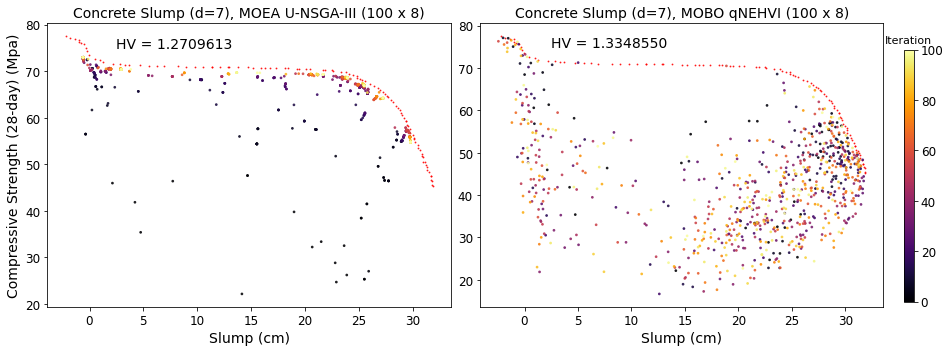

In [19]:
N_BATCH = 100
BATCH_SIZE = 8
problem = Problem
ref_point = Problem.ref_point

fig, ax = plt.subplots(ncols = 2, figsize = (14,5))

algos = ['MOEA U-NSGA-III', 'MOBO qNEHVI']

batch_number = torch.cat([torch.zeros(2*(Problem.n_var+1)),
                          torch.arange(1, N_BATCH+1).repeat(BATCH_SIZE, 1).t().reshape(-1)
                         ]).numpy()

for i, train in enumerate((train_nsga3, train_qnehvi)):

    ax[i].scatter(pareto_y[:,0],
                  pareto_y[:,1], 
                  c="r", s=3, marker=".", alpha=0.8)
    
    base_obj = train[...,problem.n_var:problem.n_var+problem.n_obj]
    real_obj = yscaler.inverse_transform(base_obj)
    
    ax[i].scatter(real_obj[:,0],
                  real_obj[:,1],
                 c=batch_number, cmap='inferno', s=3, alpha=0.8)

    ax[i].scatter(ref_point.cpu().numpy()[0],
                  ref_point.cpu().numpy()[1], 
                  c="r", s=100, marker="*")
    

    ax[i].set_title(f"Concrete Slump (d=7), {algos[i]} ({N_BATCH} x {BATCH_SIZE})", fontsize=14)
    ax[i].set_xlabel('Slump (cm)', fontsize=14)
    
    #ax[i].set_xlim(-0.2, 3)
    #ax[i].set_ylim(-0.2, 3)


ax[0].set_ylabel('Compressive Strength (28-day) (Mpa)', fontsize=14)

ax[0].text(2.5, 75, f"HV = {hvs_nsga3[-1]:.7f}", fontsize=14)
ax[1].text(2.5, 75, f"HV = {hvs_qnehvi[-1]:.7f}", fontsize=14)


#plt.setp(ax, xlim=ax[1].get_xlim(), ylim=ax[1].get_ylim())

fig.tight_layout()

norm = plt.Normalize(batch_number.min(), batch_number.max())
sm =  ScalarMappable(norm=norm, cmap='inferno')
sm.set_array([])
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration", fontsize=11)